# Importação do dataset

O dataset usado foi criado através da junção de diversas imagens, onde foi criado numpy arrays para as imagens e para as labels, respectivamente. 

Por seguinte, foi usado a biblioteca h5py para criar arquivos HDF5¹ destes numpy arrays. 

Para realizar isso, criei uma classe a parte onde foi executada localmente. O fonte desta classe pode ser encontrada aqui: [modelagem do dataset](https://github.com/gabcastro/Unisinos-AI-CNNKaggleDataset/blob/master/modelling_dataset.py).

----

¹ **HDF5** é um modelo de dados que permite que seu conteúdo possa ser facilmente manipulado – mesmo quando o tamanho do dataset ultrapassa os gigabytes

In [1]:
import h5py

from google.colab import drive
drive.mount('/content/drive/')

h5f = h5py.File('/content/drive/My Drive/Colab Notebooks/dataset_64_rgb.h5','r')
X_train = h5f['X_train'][:]
X_test = h5f['X_test'][:]
h5f.close()    

h5f = h5py.File('/content/drive/My Drive/Colab Notebooks/labels_64_rgb.h5','r')
y_train = h5f['y_train'][:]
y_test = h5f['y_test'][:]
h5f.close()   

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


# Imports

In [116]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import time
import sklearn
import urllib
import cv2

from mpl_toolkits.axes_grid1 import AxesGrid
from sklearn import metrics
from collections import Counter

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

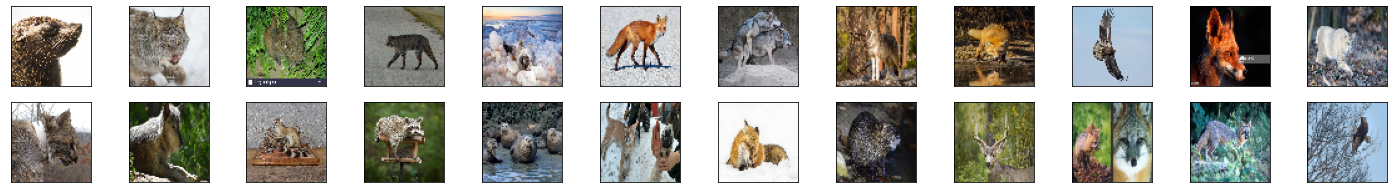

In [3]:
fig = plt.figure(figsize=(25,5))
for i in range(24):
    ax = fig.add_subplot(3,12, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_train[i]))

# Plot functions

In [4]:
def plot_loss(hist_model):
    plt.plot(hist_model.history['loss'])
    plt.plot(hist_model.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

def plot_accuracy(hist_model):
    plt.plot(hist_model.history['accuracy'])
    plt.plot(hist_model.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# Normalização

In [5]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

num_classes = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
# diminuição de 11 elementos para ficar o input e target com o mesmo número
(y_train, y_t) = y_train[11:], y_train[:11]

In [ ]:
(y_test, y_tt) = y_test[2:], y_test[:2]

In [ ]:
(X_train, x_valid) = X_train[2000:], X_train[:2000]
(y_train, y_valid) = y_train[2000:], y_train[:2000]

# Resumo dos conjuntos de dados

In [6]:
summary_shape = {}

summary_shape['X_train'] = X_train.shape
summary_shape['X_test'] = X_test.shape
# summary_shape['x_valid'] = x_valid.shape
summary_shape['y_train'] = y_train.shape
summary_shape['y_test'] = y_test.shape
# summary_shape['y_valid'] = y_valid.shape

pd.DataFrame(summary_shape.items(), columns=['In/Out', 'Total shape'])

,In/Out,Total shape
0,X_train,"(11860, 64, 64, 3)"
1,X_test,"(2094, 64, 64, 3)"
2,y_train,"(11860, 20)"
3,y_test,"(2094, 20)"


# Deep learning model(s)

In [50]:
def create_conv():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(64,64,3)))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    # model.add(Conv2D(64, (3, 3)))
    # model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, (3, 3), padding='same')) 
    model.add(Activation('relu'))
    # model.add(Conv2D(256, (3, 3)))
    # model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    opt = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True)

    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model

In [90]:
def training(model, X_train, X_test, y_train, y_test):
    
    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False
    )
    datagen.fit(X_train)

    filepath="best_weights_conv.hdf5"

    checkpoint = ModelCheckpoint(
        filepath, 
        monitor='val_acc', 
        verbose=0, 
        save_best_only=True, 
        mode='max'
    )

    callbacks_list = [LearningRateScheduler(lr_schedule), checkpoint]

    history = model.fit_generator(
        datagen.flow(X_train, y_train, batch_size=32),
        steps_per_epoch=X_train.shape[0] // 32,
        epochs=60,
        validation_data=(X_test, y_test),
        callbacks=callbacks_list
    )

    return model, history 

In [10]:
def lr_schedule(epoch):
    lr = 0.01
    return lr*(0.1**int(epoch/10))

In [51]:
model = create_conv()
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
activation_80 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 62, 62, 32)        9248      
_________________________________________________________________
activation_81 (Activation)   (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 31, 31, 64)      

In [52]:
model, history = training(model, X_train, X_test, y_train, y_test)

Epoch 1/60
370/370 [==============================] - 15s 40ms/step - loss: 2.9044 - accuracy: 0.0971 - val_loss: 2.8139 - val_accuracy: 0.1734
Epoch 2/60
  2/370 [..............................] - ETA: 24s - loss: 2.8546 - accuracy: 0.1719

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


370/370 [==============================] - 14s 39ms/step - loss: 2.6623 - accuracy: 0.1859 - val_loss: 2.6086 - val_accuracy: 0.1858
Epoch 3/60
370/370 [==============================] - 14s 39ms/step - loss: 2.5187 - accuracy: 0.2252 - val_loss: 2.4940 - val_accuracy: 0.2574
Epoch 4/60
370/370 [==============================] - 15s 40ms/step - loss: 2.4152 - accuracy: 0.2548 - val_loss: 2.2872 - val_accuracy: 0.3018
Epoch 5/60
370/370 [==============================] - 14s 39ms/step - loss: 2.2957 - accuracy: 0.2898 - val_loss: 2.1768 - val_accuracy: 0.3434
Epoch 6/60
370/370 [==============================] - 14s 38ms/step - loss: 2.2011 - accuracy: 0.3204 - val_loss: 2.0664 - val_accuracy: 0.3949
Epoch 7/60
370/370 [==============================] - 14s 38ms/step - loss: 2.1091 - accuracy: 0.3476 - val_loss: 1.9435 - val_accuracy: 0.4164
Epoch 8/60
370/370 [==============================] - 14s 38ms/step - loss: 2.0094 - accuracy: 0.3801 - val_loss: 1.8687 - val_accuracy: 0.4575
Epo

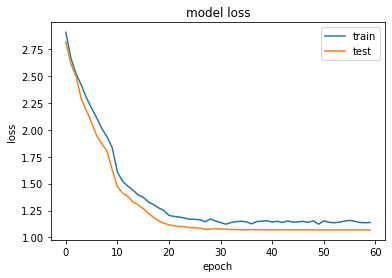

In [53]:
plot_loss(history)

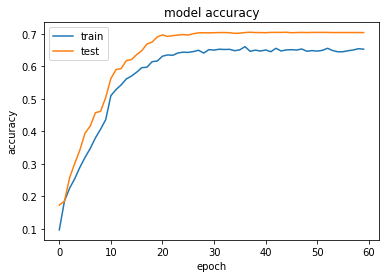

In [54]:
plot_accuracy(history)

In [89]:
dist = {
    k: tuple(d[k] for d in [dict(Counter(np.where(y_train==1)[1])), dict(Counter(np.where(y_test==1)[1]))]) for k in range(num_classes)
}

map_animals = {
    0: 'bald_eagle',
    1: 'black_bear',
    2: 'bobcat',
    3: 'canada_lynx',
    4: 'columbian_black-tailed_deer',
    5: 'cougar',
    6: 'coyote',
    7: 'deer',
    8: 'elk',
    9: 'gray_fox',
    10: 'gray_wolf',
    11: 'mountain_beaver',
    12: 'nutria',
    13: 'raccoon',
    14: 'raven',
    15: 'red_fox',
    16: 'ringtail',
    17: 'sea_lions',
    18: 'seals',
    19: 'virginia_opossum'
}

summ_train = {}
summ_test = {}

for k, v in sorted(dist.items(), key = lambda x:x[1][0], reverse=True):
    summ_train[map_animals[k]] = v[0]
    summ_test[map_animals[k]] = v[1]

df1 = pd.DataFrame(summ_train.items(), columns=['Class', 'Total train'])
df2 = pd.DataFrame(summ_test.values(), columns=['Total test'])

summary_num_data = pd.concat([df1, df2], axis=1, sort=False)

summary_num_data

,Class,Total train,Total test
0,red_fox,655,103
1,deer,653,110
2,columbian_black-tailed_deer,625,110
3,coyote,625,111
4,gray_wolf,622,108
5,raccoon,620,104
6,canada_lynx,618,98
7,sea_lions,618,106
8,bald_eagle,615,127
9,virginia_opossum,600,127


In [96]:
y_pred = model.predict(X_test)
print('\n', 
    sklearn.metrics.classification_report(
        np.where(y_test > 0)[1], 
        np.argmax(y_pred, axis=1), 
        target_names=list(map_animals.values())), sep='')


                             precision    recall  f1-score   support

                 bald_eagle       0.83      0.83      0.83       127
                 black_bear       0.84      0.88      0.86       117
                     bobcat       0.52      0.47      0.50       110
                canada_lynx       0.66      0.64      0.65        98
columbian_black-tailed_deer       0.70      0.75      0.72       110
                     cougar       0.82      0.59      0.69       111
                     coyote       0.75      0.64      0.69       111
                       deer       0.59      0.67      0.63       110
                        elk       0.71      0.78      0.74        95
                   gray_fox       0.70      0.58      0.63        95
                  gray_wolf       0.65      0.74      0.69       108
            mountain_beaver       0.82      0.70      0.76        88
                     nutria       0.69      0.67      0.68        97
                    raccoon     

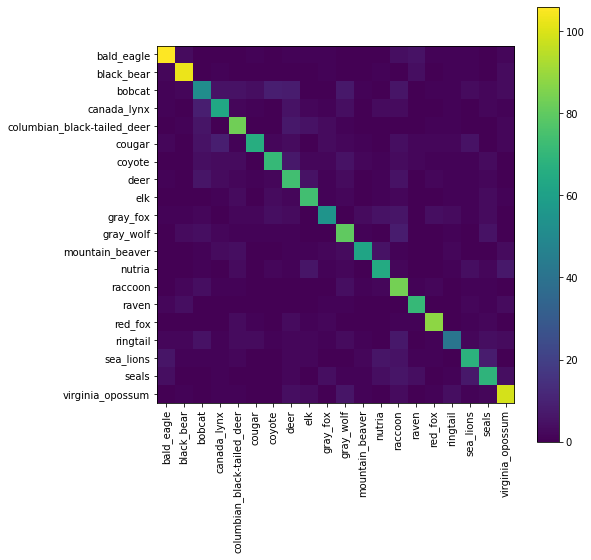

In [97]:
plt.figure(figsize=(8,8))
cnf_matrix = sklearn.metrics.confusion_matrix(np.where(y_test > 0)[1], np.argmax(y_pred, axis=1))
classes = list(map_animals.values())
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

In [149]:
def url_to_image(url):
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    return image

def plot_and_predict(url, all_perc=False):
    image = url_to_image(url)
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    pic = cv2.resize(img, (64,64))
    a = model.predict_proba(pic.reshape(1, 64, 64,3))[0]
    if all_perc:
        print('\n'.join(['{} : {}%'.format(map_animals[i], round(k*100)) for i,k in sorted(enumerate(a), key=lambda x:x[1], reverse=True)]))
    else:
        return map_animals[np.argmax(a)].replace('_',' ').title()

def map_porcent_predict(url):
    
    F = plt.figure(1, (15,20))
    grid = AxesGrid(F, 111,  # similar to subplot(141)
        nrows_ncols=(1, 3),
        axes_pad=0,
        label_mode="1")
    
    it = 0

    for i in [0, 7, 8]:
        char = map_animals[i]
        image = url_to_image(url[it])
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        pic = cv2.resize(img, (64,64)).astype('float32')/255.
        a = model.predict(pic.reshape(1,64,64,3))[0]
        actual = char.split('_')[0].title()
        text = sorted(['{:s} : {:.1f}%'.format(map_animals[k].split('_')[0].title(), 100*v) for k,v in enumerate(a)], 
            key=lambda x:float(x.split(':')[1].split('%')[0]), reverse=True)[:3]
        img = cv2.resize(img, (352, 352))
        cv2.rectangle(img, (0,260),(215,352),(255,255,255), -1)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, 'Actual : %s' % actual, (10, 280), font, 0.7,(0,0,0),2,cv2.LINE_AA)
        for k, t in enumerate(text):
            cv2.putText(img, t,(10, 300+k*18), font, 0.65,(0,0,0),2,cv2.LINE_AA)
        grid[it].imshow(img)            
        it += 1

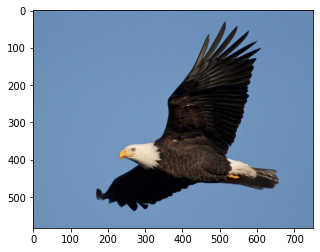

'Raven'

In [137]:
url = "https://nature.mdc.mo.gov/sites/default/files/styles/centered_full/public/media/images/2013/11/bald_eagle_flying_11-20-13.jpg?itok=ZQZo0D-Q"
plot_and_predict(url)

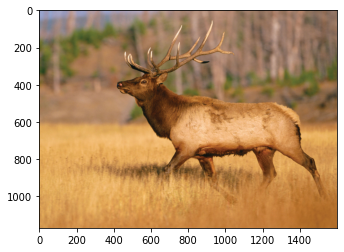

'Deer'

In [138]:
url = "https://cdn.britannica.com/03/94603-050-D74D3709/elk-American-Yellowstone-National-Park-Wyoming.jpg"
plot_and_predict(url)

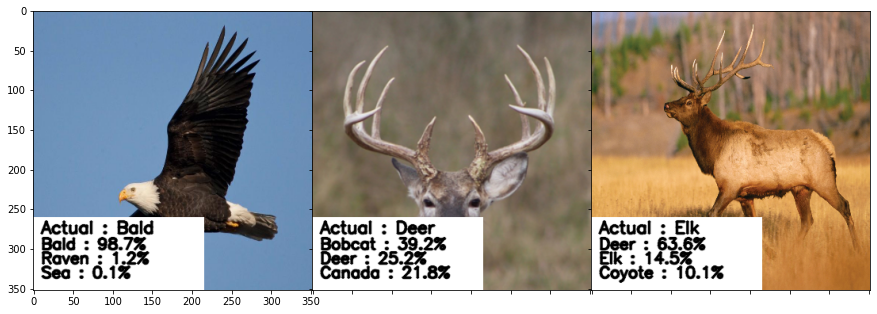

In [150]:
url = [
    "https://nature.mdc.mo.gov/sites/default/files/styles/centered_full/public/media/images/2013/11/bald_eagle_flying_11-20-13.jpg?itok=ZQZo0D-Q", #bald_eagle
    "https://tpwd.texas.gov/huntwild/wild/game_management/deer/images/WTD-Headshot.jpg", # deer
    "https://cdn.britannica.com/03/94603-050-D74D3709/elk-American-Yellowstone-National-Park-Wyoming.jpg" # elk
] 
map_porcent_predict(url)